In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# For nicer plots
sns.set(style='whitegrid')

In [2]:
# Read the CSV from archive.zip
# Pandas can read directly if the ZIP contains only one CSV
data = pd.read_csv("archive.zip")

# Display first few rows
data.head()


,pokedex_number,name,attack,defense,height_m,hp,percentage_male,sp_attack,sp_defense,speed,type,weight_kg,generation,is_legendary
0,1,Bulbasaur,49,49,0.7,45,88.1,65,65,45,grass,6.9,1,0
1,2,Ivysaur,62,63,1.0,60,88.1,80,80,60,grass,13.0,1,0
2,3,Venusaur,100,123,2.0,80,88.1,122,120,80,grass,100.0,1,0
3,4,Charmander,52,43,0.6,39,88.1,60,50,65,fire,8.5,1,0
4,5,Charmeleon,64,58,1.1,58,88.1,80,65,80,fire,19.0,1,0


Shape of dataset: (801, 14)

Columns:
 Index(['pokedex_number', 'name', 'attack', 'defense', 'height_m', 'hp',
       'percentage_male', 'sp_attack', 'sp_defense', 'speed', 'type',
       'weight_kg', 'generation', 'is_legendary'],
      dtype='object')

Missing values:
 pokedex_number      0
name                0
attack              0
defense             0
height_m           20
hp                  0
percentage_male    98
sp_attack           0
sp_defense          0
speed               0
type                0
weight_kg          20
generation          0
is_legendary        0
dtype: int64

Legendary distribution:
is_legendary
0    731
1     70
Name: count, dtype: int64


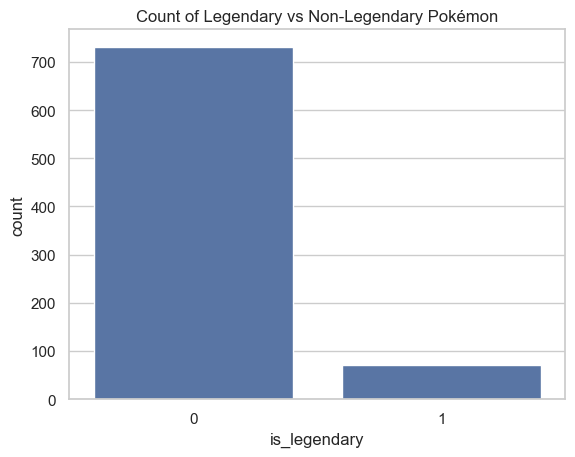

In [3]:
print("Shape of dataset:", data.shape)
print("\nColumns:\n", data.columns)
print("\nMissing values:\n", data.isnull().sum())

# Check for Legendary column (may differ by dataset)
if 'Legendary' in data.columns:
    legend_col = 'Legendary'
elif 'is_legendary' in data.columns:
    legend_col = 'is_legendary'
else:
    legend_col = None

if legend_col:
    print("\nLegendary distribution:")
    print(data[legend_col].value_counts())
    sns.countplot(x=legend_col, data=data)
    plt.title("Count of Legendary vs Non-Legendary Pokémon")
    plt.savefig("legendary_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nNo 'Legendary' column found. Clustering will be unsupervised only.")


In [4]:
# Choose meaningful combat stats only
features_to_use = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']

# Keep only features that exist in CSV
features_to_use = [f for f in features_to_use if f in data.columns]

# Extract numeric data
X = data[features_to_use].copy()

# Min-Max scaling
X_scaled = (X - X.min()) / (X.max() - X.min())

# Quick check of scaling
print("Columns used for clustering:", features_to_use)
print("\nMin values:\n", X_scaled.min())
print("\nMax values:\n", X_scaled.max())


Columns used for clustering: ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']

Min values:
 hp            0.0
attack        0.0
defense       0.0
sp_attack     0.0
sp_defense    0.0
speed         0.0
dtype: float64

Max values:
 hp            1.0
attack        1.0
defense       1.0
sp_attack     1.0
sp_defense    1.0
speed         1.0
dtype: float64


In [5]:
indices = np.arange(len(X_scaled))
np.random.shuffle(indices)

split = int(0.8 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]

X_train = X_scaled.iloc[train_idx].values
X_val   = X_scaled.iloc[val_idx].values

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))


Training samples: 640
Validation samples: 161


In [6]:
class KMeansScratch:
    def __init__(self, k=3, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol

    def initialize_centroids(self, X):
        idx = np.random.choice(X.shape[0], self.k, replace=False)
        return X[idx]

    def assign_clusters(self, X, centroids):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        return np.argmin(distances, axis=1)

    def update_centroids(self, X, labels):
        centroids = []
        for i in range(self.k):
            if np.any(labels == i):
                centroids.append(X[labels == i].mean(axis=0))
            else:
                # Reinitialize empty cluster randomly
                centroids.append(X[np.random.randint(0, X.shape[0])])
        return np.array(centroids)

    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        for _ in range(self.max_iters):
            labels = self.assign_clusters(X, self.centroids)
            new_centroids = self.update_centroids(X, labels)
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break
            self.centroids = new_centroids
        self.labels_ = labels
        return self

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)


In [7]:
# Initialize K-Means with k=3 clusters
kmeans = KMeansScratch(k=3, max_iters=100)
kmeans.fit(X_train)

# Predict cluster assignments on validation set
val_labels = kmeans.predict(X_val)

print("Cluster assignments (first 10):", val_labels[:10])


Cluster assignments (first 10): [1 0 0 0 2 1 0 1 1 0]


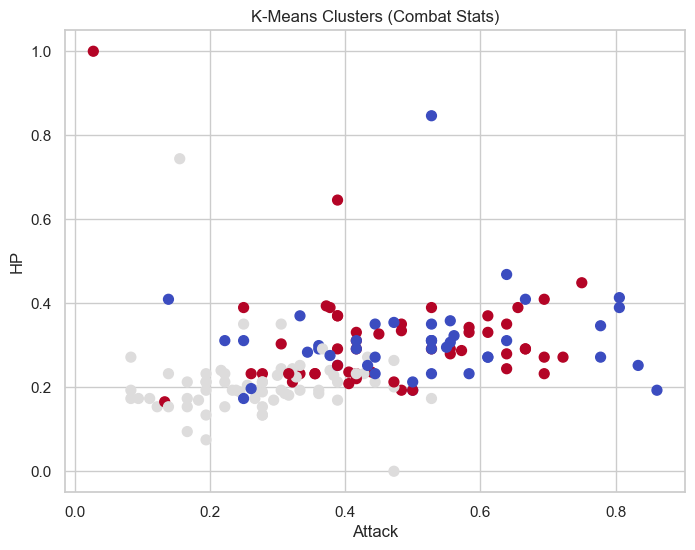

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(X_val[:, features_to_use.index('attack')],
            X_val[:, features_to_use.index('hp')],
            c=val_labels, cmap='coolwarm', s=50)
plt.xlabel('Attack')
plt.ylabel('HP')
plt.title('K-Means Clusters (Combat Stats)')
plt.savefig("kmeans_clusters_combat_stats.png", dpi=300, bbox_inches='tight')
plt.show()


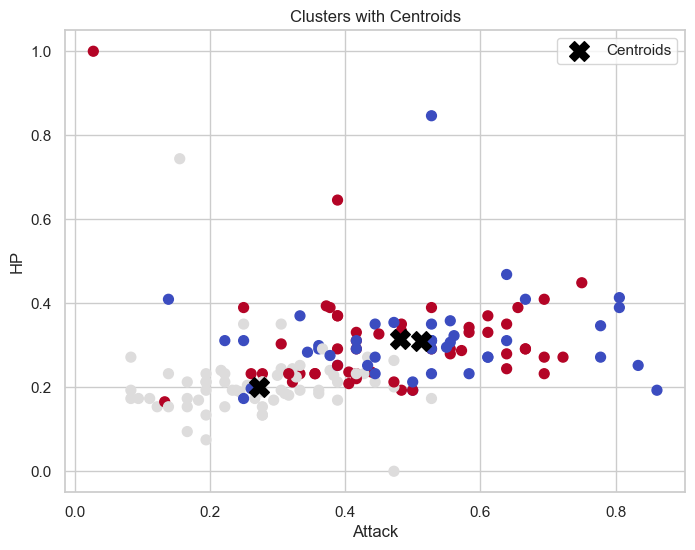

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(X_val[:, features_to_use.index('attack')],
            X_val[:, features_to_use.index('hp')],
            c=val_labels, cmap='coolwarm', s=50)
plt.scatter(kmeans.centroids[:, features_to_use.index('attack')],
            kmeans.centroids[:, features_to_use.index('hp')],
            c='black', marker='X', s=200, label='Centroids')
plt.xlabel('Attack')
plt.ylabel('HP')
plt.title('Clusters with Centroids')
plt.legend()
plt.savefig("clusters_with_centroids.png", dpi=300, bbox_inches='tight')
plt.show()


In [10]:
if legend_col:
    y_val = data[legend_col].iloc[val_idx].values
    y_val_num = np.where(y_val==True, 1, 0)

    # Purity Score
    def purity_score(y_true, y_pred):
        clusters = np.unique(y_pred)
        total = 0
        for c in clusters:
            members = y_true[y_pred == c]
            if len(members) > 0:
                total += np.max(np.bincount(members.astype(int)))
        return total / len(y_true)

    purity = purity_score(y_val_num, val_labels)
    print("Purity Score:", round(purity,4))
else:
    print("Legendary column not found; skipping metrics.")


Purity Score: 0.9068
